# Step 1: Load and preprocess data

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('./cleaned_dataset/shuffled_data.csv')

# Preview
print(df.head())
print(df.columns)

# Convert timestamp to datetime object
df['time'] = pd.to_datetime(df['time'])

# Extract useful features from timestamp
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['dayofweek'] = df['time'].dt.dayofweek

# Now drop the original string column
df.drop(columns=['time'], inplace=True)

# Proceed to separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split (optional for testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


                  time  switch_id  gfe  g_usip      rfip  disp_pakt  \
0  2023-02-21 08:08:38          2    0       0  1.000000   2.683282   
1  2023-02-21 06:31:50          3    0       0  1.000000  23.851974   
2  2022-11-15 08:02:37         15    1       0  0.333333   0.000000   
3  2022-11-15 07:24:03         15    0       0  0.500000  22.978251   
4  2023-02-03 22:10:58          1  157     157  0.000000   0.000000   

      disp_byte  mean_pkt  mean_byte  gsp     avg_durat  avg_flow_dst  \
0  2.629616e+02      3.00      294.0    0  3.960000e+17             6   
1  1.104434e+06    420.75   912497.5    0  4.790000e+17             4   
2  0.000000e+00      0.00        0.0    1  3.960000e+17             5   
3  3.474311e+04     14.00    21168.0    0  6.690000e+17             4   
4  0.000000e+00      0.00        0.0  157  4.720000e+17         28232   

    rate_pkt_in  disp_interval  label  
0    367.666667   1.620000e+17      0  
1    191.333333   7.380000e+16      2  
2  26758.20000

# Step 2: Define environment for RL

In [2]:
# ! pip install gym

In [21]:
import gym
from gym import spaces

# Custom Gym environment
class DDoSEnv(gym.Env):
    def __init__(self, X, y):
        super(DDoSEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.max_steps = len(X)
        self.action_space = spaces.Discrete(2)  # 0 = ignore, 1 = alert
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self):
        self.index = 0
        return self.X[self.index]

    def step(self, action):
        label = self.y[self.index]
        done = self.index >= self.max_steps - 1
        reward = 0
        alarm = None

        if action == 1 and label == 1:
            reward = 1
            alarm = True
        elif action == 0 and label == 1:
            reward = -1
            alarm = False
        elif action == 1 and label == 0:
            reward = -0.5
            alarm = False
        else:
            reward = 0.5
            alarm = False

        self.index += 1
        obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        return obs, reward, done, {'alarm': alarm, 'label': label, 'action': action}

# Step 3: DQN Agent with PyTorch

In [4]:
# ! pip install pytorch torch

In [5]:
# ! pip install torch

In [22]:
import torch.nn as nn
import torch.optim as optim
import torch
import random
from collections import deque

# Simple DQN Agent
class DQNAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNAgent, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Step 4: Training loop

In [23]:
import random
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming DDoSEnv is defined elsewhere and X_train, y_train are loaded
# For demonstration purposes, let's create dummy data if not available
if 'X_train' not in locals():
    X_train = np.random.rand(100, 10)
    y_train = pd.Series(np.random.randint(0, 2, 100))

# Set up environment and agent
env = DDoSEnv(X_train, y_train.values)
input_dim = X_train.shape[1]
output_dim = env.action_space.n

class DQNAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

agent = DQNAgent(input_dim, output_dim)
optimizer = optim.Adam(agent.parameters(), lr=0.001)
criterion = nn.MSELoss()

replay_buffer = deque(maxlen=10000)
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
episodes = 50

# For final alarm detection
correct_ddos_detections = 0
total_ddos_attacks = 0

for ep in range(episodes):
    state = env.reset()
    done = False

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0) # Add batch dimension
                q_values = agent(state_tensor)
                action = q_values.argmax().item()

        next_state, reward, done, info = env.step(action)

        # Store experience
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state

        # Count DDoS logic only in last episode
        if ep == episodes - 1 and info['label'] == 1:
            total_ddos_attacks += 1
            if info['action'] == 1:
                correct_ddos_detections += 1

        # Train agent
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)  # Convert list of numpy arrays to a single numpy array
            next_states = np.array(next_states) # Convert list of numpy arrays to a single numpy array

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(list(actions)).unsqueeze(1)
            rewards = torch.FloatTensor(list(rewards)).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(list(dones)).unsqueeze(1)

            q_values = agent(states).gather(1, actions)
            with torch.no_grad():
                next_q_values = agent(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

# Final detection logic
if total_ddos_attacks > 0 and (correct_ddos_detections / total_ddos_attacks) >= 0.4:
    print("🚨 FINAL OUTPUT: DDoS Attack Detected (Correct detections: {:.2f}%)".format(
        100 * correct_ddos_detections / total_ddos_attacks))
else:
    print("✅ FINAL OUTPUT: No DDoS Detected (Correct detections: {:.2f}%)".format(
        100 * correct_ddos_detections / total_ddos_attacks if total_ddos_attacks else 0))

🚨 FINAL OUTPUT: DDoS Attack Detected (Correct detections: 60.98%)


In [24]:
import os

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

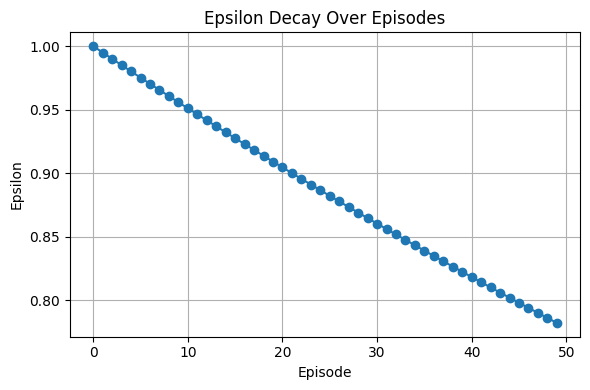

In [25]:
# Epsilon Decay over Episodes
epsilon_values = [1.0 * (epsilon_decay ** i) if (1.0 * (epsilon_decay ** i)) > epsilon_min else epsilon_min for i in range(episodes)]

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(episodes), epsilon_values, marker='o')
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("results/epsilon_decay.png")
plt.close()

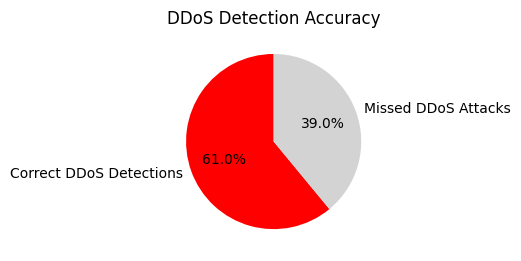

In [26]:
# Detection Summary Pie Chart
labels = ['Correct DDoS Detections', 'Missed DDoS Attacks']
sizes = [correct_ddos_detections, total_ddos_attacks - correct_ddos_detections]
colors = ['red', 'lightgrey']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("DDoS Detection Accuracy")
plt.tight_layout()
plt.show()
plt.savefig("results/ddos_detection_pie.png")
plt.close()


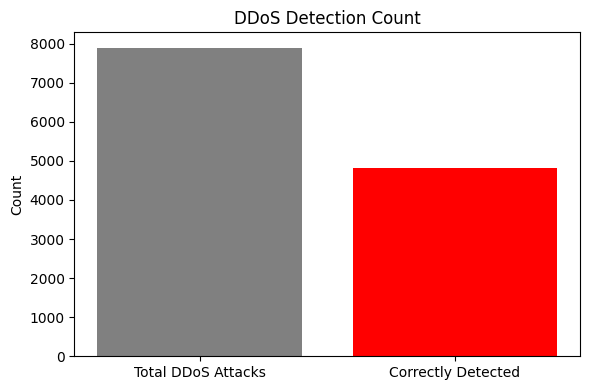

In [27]:
# Bar Chart – Total vs Correct Detections
plt.figure(figsize=(6,4))
plt.bar(['Total DDoS Attacks', 'Correctly Detected'], [total_ddos_attacks, correct_ddos_detections], color=['gray', 'red'])
plt.title("DDoS Detection Count")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.savefig("results/ddos_detection_bar.png")
plt.close()